## Load Data

In [1]:
from utils.concatenate_data import run_pipeline
import pandas as pd
all_data_df, long_df = run_pipeline(
    root_xlsx_dir="Load-data",
    cleaned_csv_dir="cleaned_data",
    
    preprocessed_csv_dir="preprocessed_data",
    final_wide_csv="all_data_df.csv",
    final_long_csv="all_data_timeseries.csv",
)
def preprocess(long_df):
    long_df.loc[long_df['Electricity(kW)'] < 0, 'Electricity(kW)'] = 0
    return long_df
long_df = preprocess(long_df)

from utils.build_station_weight import build_station_weights
station_weights_df = build_station_weights(long_df)
print(station_weights_df)

locations = {
    "Data_สถานีชาร์จ": (13.736418765099916, 100.52524210026607), # Corrected coordinates is 13.736418765099916, 100.52524210026607
    "Data_อาคารจามจุรี4": (13.738963239687536, 100.52843073814955), # Corrected coordinates is 13.738963239687536, 100.52843073814955
    "Data_อาคารจามจุรี 9": (13.735899096644642, 100.52550388047727), # Corrected coordinates is 13.735899096644642, 100.52550388047727
    "Data_อาคารจุลจักรพงษ์": (13.73558133067766, 100.5309154651327), # Corrected coordinates is 13.73558133067766, 100.5309154651327
    "Data_อาคารบรมราชกุมารี": (13.739340161417255, 100.53355852280504), # Corrected coordinates is 13.739340161417255, 100.53355852280504
    "Data_อาคารวิทยนิเวศน์": (13.740842756926996, 100.5269634228051), # Corrected coordinates is 13.740842756926996, 100.5269634228051
}
def split_train_test_data(long_df,long_df_new):
    # Define ratios
    train_ratio = 0.8
    test_ratio = 0.2  # Optional, just for clarity (1 - train_ratio)
    
    # Create empty lists to collect per-station splits
    train_list = []
    test_list = []
    
    # Split per station
    for station, station_df in long_df_new.groupby('station_name'):
        station_df = station_df.sort_values('Date')
        n = len(station_df)
    
        train_end = int(n * train_ratio)
    
        train_list.append(station_df.iloc[:train_end])
        test_list.append(station_df.iloc[train_end:])
    
    # Combine all stations back into global sets
    train_df = pd.concat(train_list).reset_index(drop=True)
    # Create empty lists to collect per-station splits
    train_list = []
    test_list = []
    for station, station_df in long_df.groupby('station_name'):
        station_df = station_df.sort_values('Date')
        n = len(station_df)
    
        train_end = int(n * train_ratio)
    
        train_list.append(station_df.iloc[:train_end])
        test_list.append(station_df.iloc[train_end:])
    
    test_df_new = pd.concat(test_list).reset_index(drop=True)
    
    return train_df,test_df_new
train_df,test_df = split_train_test_data(long_df,long_df)

             station_name  normalized_reverse_weight
0         Data_สถานีชาร์จ                   1.000000
1     Data_อาคารจามจุรี 9                   1.000000
2   Data_อาคารจุลจักรพงษ์                   1.002786
3  Data_อาคารบรมราชกุมารี                   1.002786
4      Data_อาคารจามจุรี4                   1.094225
5   Data_อาคารวิทยนิเวศน์                   2.384106


## Call Model

In [2]:
# Example usage of the InferenceModel model

import numpy as np
import torch
import onnxruntime as ort

class InferenceModel:
    def __init__(self, onnx_path="astgcn_v2.onnx", device="cpu"):
        providers = (["CUDAExecutionProvider","CPUExecutionProvider"]
                     if device.startswith("cuda") else ["CPUExecutionProvider"])
        self.sess = ort.InferenceSession(onnx_path, providers=providers)

        # Inspect the ONNX inputs
        inputs = self.sess.get_inputs()
        names = [inp.name for inp in inputs]
        if len(names) == 2:
            # graph expects [X, edge_index]
            self.input_name, self.edge_name = names
            self.need_edge = True
        elif len(names) == 1:
            # graph only expects [X], edge_index is built-in
            self.input_name = names[0]
            self.edge_name = None
            self.need_edge = False
        else:
            raise RuntimeError(f"Unexpected number of inputs in ONNX model: {len(names)}")

        self.output_name = self.sess.get_outputs()[0].name

    def forecast(self, X: torch.Tensor, edge_index: torch.Tensor = None) -> torch.Tensor:
        """
        X: [B, N, 1, seq_len]
        edge_index: [2, E] (only required if the ONNX session expects it)
        """
        Xn = X.cpu().numpy().astype(np.float32)
        feed = {self.input_name: Xn}

        if self.need_edge:
            if edge_index is None:
                raise ValueError("This model requires edge_index, but none was given.")
            En = edge_index.cpu().numpy().astype(np.int64)
            feed[self.edge_name] = En

        out = self.sess.run([self.output_name], feed)[0]
        return torch.from_numpy(out)

locations = {
    "Data_สถานีชาร์จ": (13.736418765099916, 100.52524210026607), # Corrected coordinates is 13.736418765099916, 100.52524210026607
    "Data_อาคารจามจุรี4": (13.738963239687536, 100.52843073814955), # Corrected coordinates is 13.738963239687536, 100.52843073814955
    "Data_อาคารจามจุรี 9": (13.735899096644642, 100.52550388047727), # Corrected coordinates is 13.735899096644642, 100.52550388047727
    "Data_อาคารจุลจักรพงษ์": (13.73558133067766, 100.5309154651327), # Corrected coordinates is 13.73558133067766, 100.5309154651327
    "Data_อาคารบรมราชกุมารี": (13.739340161417255, 100.53355852280504), # Corrected coordinates is 13.739340161417255, 100.53355852280504
    "Data_อาคารวิทยนิเวศน์": (13.740842756926996, 100.5269634228051), # Corrected coordinates is 13.740842756926996, 100.5269634228051
}

# ── 1) Setup device, data, and model ─────────────────────────────────────────
device = torch.device("cpu")
print(f"Using device: {device}")

# define your station list and ONNX path
station_names = list(locations.keys())
onnx_path = "./model/astgcnv2_50epoch.onnx"

# build full-edge_index tensor once
num_nodes = len(station_names)
edge_index = torch.tensor(
    [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
    dtype=torch.long,
).t().contiguous().to(device)

# instantiate the ONNX inference session
inf = InferenceModel(onnx_path, device=str(device))

Using device: cpu


## Make Prediction on Testset

In [3]:
import numpy as np
import torch
import onnxruntime as ort
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
import pandas as pd
from tqdm.auto import tqdm
# ── 2) Prepare sliding-window inputs ─────────────────────────────────────────
len_input = 96
prediction_length = 96

# concatenate train+test, pivot to wide, fill missing
df_all = pd.concat([train_df, test_df], ignore_index=True)
pivot = (df_all
         .pivot(index='Date', columns='station_name', values='Electricity(kW)')
         .reindex(columns=station_names)
         .fillna(0.0))
dates = pivot.index
T = len(dates)

# extract all windows of length len_input
max_start = T - len_input - prediction_length + 1
windows = []
for t0 in range(max_start):
    arr = pivot.iloc[t0:t0+len_input].values   # (len_input, N)
    windows.append(arr.T)                      # → (N, len_input)
X_all = np.stack(windows, axis=0)             # (W, N, len_input)
X_all = torch.from_numpy(X_all).float().unsqueeze(2)  # (W, N, 1, len_input)

# ── 3) Run inference in batches ──────────────────────────────────────────────
batch_size = 512
loader = DataLoader(TensorDataset(X_all), batch_size=batch_size, shuffle=False)

all_preds = []
inf.sess  # warm up if necessary
for (Xb,) in tqdm(loader, desc="ONNX batches"):
    Xb = Xb.to(device)
    # ONNX forecast returns Tensor of shape (B, N, pred_len)
    yb = inf.forecast(Xb, edge_index)
    all_preds.append(yb.cpu().numpy())

preds = np.concatenate(all_preds, axis=0)  # (W, N, prediction_length)

# ── 4) Take first‐step horizon ───────────────────────────────────────────────
first_step = preds[:, :, 0]               # (W, N)
pred_dates = dates[len_input : len_input + first_step.shape[0]]

# ── 5) Build DataFrame of point‐forecasts ───────────────────────────────────
records = []
for w, dt in enumerate(pred_dates):
    for i, station in enumerate(station_names):
        records.append((dt, station, first_step[w, i]))
df_preds = pd.DataFrame(records, columns=['Date','station_name','Predicted(kW)'])

# ── 6) Merge with test_df and evaluate MAE ──────────────────────────────────
df_merged = (test_df
             .merge(df_preds, on=['Date','station_name'], how='left')
             .sort_values(['Date','station_name'])
             .reset_index(drop=True))
df_eval = df_merged.dropna(subset=['Predicted(kW)'])

c:\Users\patar\miniconda3\envs\superai-intern-lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ONNX batches: 100%|██████████| 68/68 [05:04<00:00,  4.48s/it]


In [5]:
df_eval

,station_name,Date,Electricity(kW),Predicted(kW)
0,Data_อาคารวิทยนิเวศน์,2024-05-01 19:00:00,0.00,1.384574
1,Data_อาคารวิทยนิเวศน์,2024-05-01 19:15:00,0.00,1.422141
2,Data_อาคารวิทยนิเวศน์,2024-05-01 19:30:00,0.00,1.422141
3,Data_อาคารวิทยนิเวศน์,2024-05-01 19:45:00,0.00,1.422141
4,Data_อาคารวิทยนิเวศน์,2024-05-01 20:00:00,0.00,1.422141
...,...,...,...,...
36347,Data_สถานีชาร์จ,2024-11-27 00:00:00,0.01,15.519713
36348,Data_อาคารจามจุรี 9,2024-11-27 00:00:00,106.00,134.658936
36349,Data_อาคารจามจุรี4,2024-11-27 00:00:00,6.00,30.605927
36350,Data_อาคารจุลจักรพงษ์,2024-11-27 00:00:00,22.00,2.012923


### Evaluation Metric

**Mean Absolute Error (MAE)**  
$$[
\mathrm{MAE} \;=\; \frac{1}{N} \sum_{i=1}^{N} \bigl|\hat{y}_i - y_i\bigr|
$$]

---

**Mean Squared Error (MSE)**  
$$
\mathrm{MSE} \;=\; \frac{1}{N} \sum_{i=1}^{N} \bigl(\hat{y}_i - y_i\bigr)^{2}
$$

---

**Root Mean Squared Error (RMSE)**  
$$
\mathrm{RMSE} \;=\; \sqrt{\frac{1}{N} \sum_{i=1}^{N} \bigl(\hat{y}_i - y_i\bigr)^{2}} \;=\;\sqrt{\mathrm{MSE}}
$$

---

**Weighted Absolute Percentage Error (WAPE)**  
$$
\mathrm{WAPE} \;=\; \frac{\displaystyle \sum_{i=1}^{N} w_i \,\bigl|\hat{y}_i - y_i\bigr|}{\displaystyle \sum_{i=1}^{N} w_i \, y_i}
$$
where \(w_i\) is the normalized reverse weight for the station of sample \(i\).

---

In the above:

- \(N\) is the total number of forecast points (across all windows and stations).  
- \(\hat{y}_i\) is the predicted value at point \(i\).  
- \(y_i\) is the true (actual) value at point \(i\).  
- \(w_i\) is the weight associated with point \(i\), taken from `normalized_reverse_weight`.  



In [14]:
from utils.error_analyzer import  compute_station_metrics
metrics_df = compute_station_metrics(df_eval, station_weights_df)
metrics_df

c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\utils\error_analyzer.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_metrics)


,station_name,MAE,MSE,RMSE,WAPE
0,Data_สถานีชาร์จ,24.859462,2132.403292,46.177952,0.431156
1,Data_อาคารจามจุรี 9,106.093282,20050.680832,141.600427,0.423205
2,Data_อาคารจามจุรี4,38.236568,2506.349435,50.063454,1.183056
3,Data_อาคารจุลจักรพงษ์,12.771371,238.835992,15.45432,0.189983
4,Data_อาคารบรมราชกุมารี,18.189612,791.693026,28.13704,0.174851
5,Data_อาคารวิทยนิเวศน์,3.016486,19.018113,4.360976,1.200638
6,all_station,37.1323,4783.155795,69.160363,0.394926


### Visualize predicted vs actual (Overall)

In [91]:
from utils.error_analyzer import plot_all_stations_with_overall
# Usage:
plot_all_stations_with_overall(df_eval, metrics_df)


ImportError: cannot import name 'plot_all_stations_with_overall' from 'utils.error_analyzer' (c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\utils\error_analyzer.py)

### Visualize predicted vs actual (Deeper)

In [59]:
from utils.error_analyzer import plot_all_stations_with_daily_ticks
# Usage:
plot_all_stations_with_daily_ticks(df_eval, metrics_df, show_daily_grid=True, daily_tick_interval=1)


ImportError: cannot import name 'plot_all_stations_with_daily_ticks' from 'utils.error_analyzer' (c:\Users\patar\Documents\superai-intern\superaiss5-intern-vpp\utils\error_analyzer.py)

### 7d Analysis

C:\Users\patar\AppData\Local\Temp\ipykernel_4064\936550846.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(['station_name','weekday']).agg(


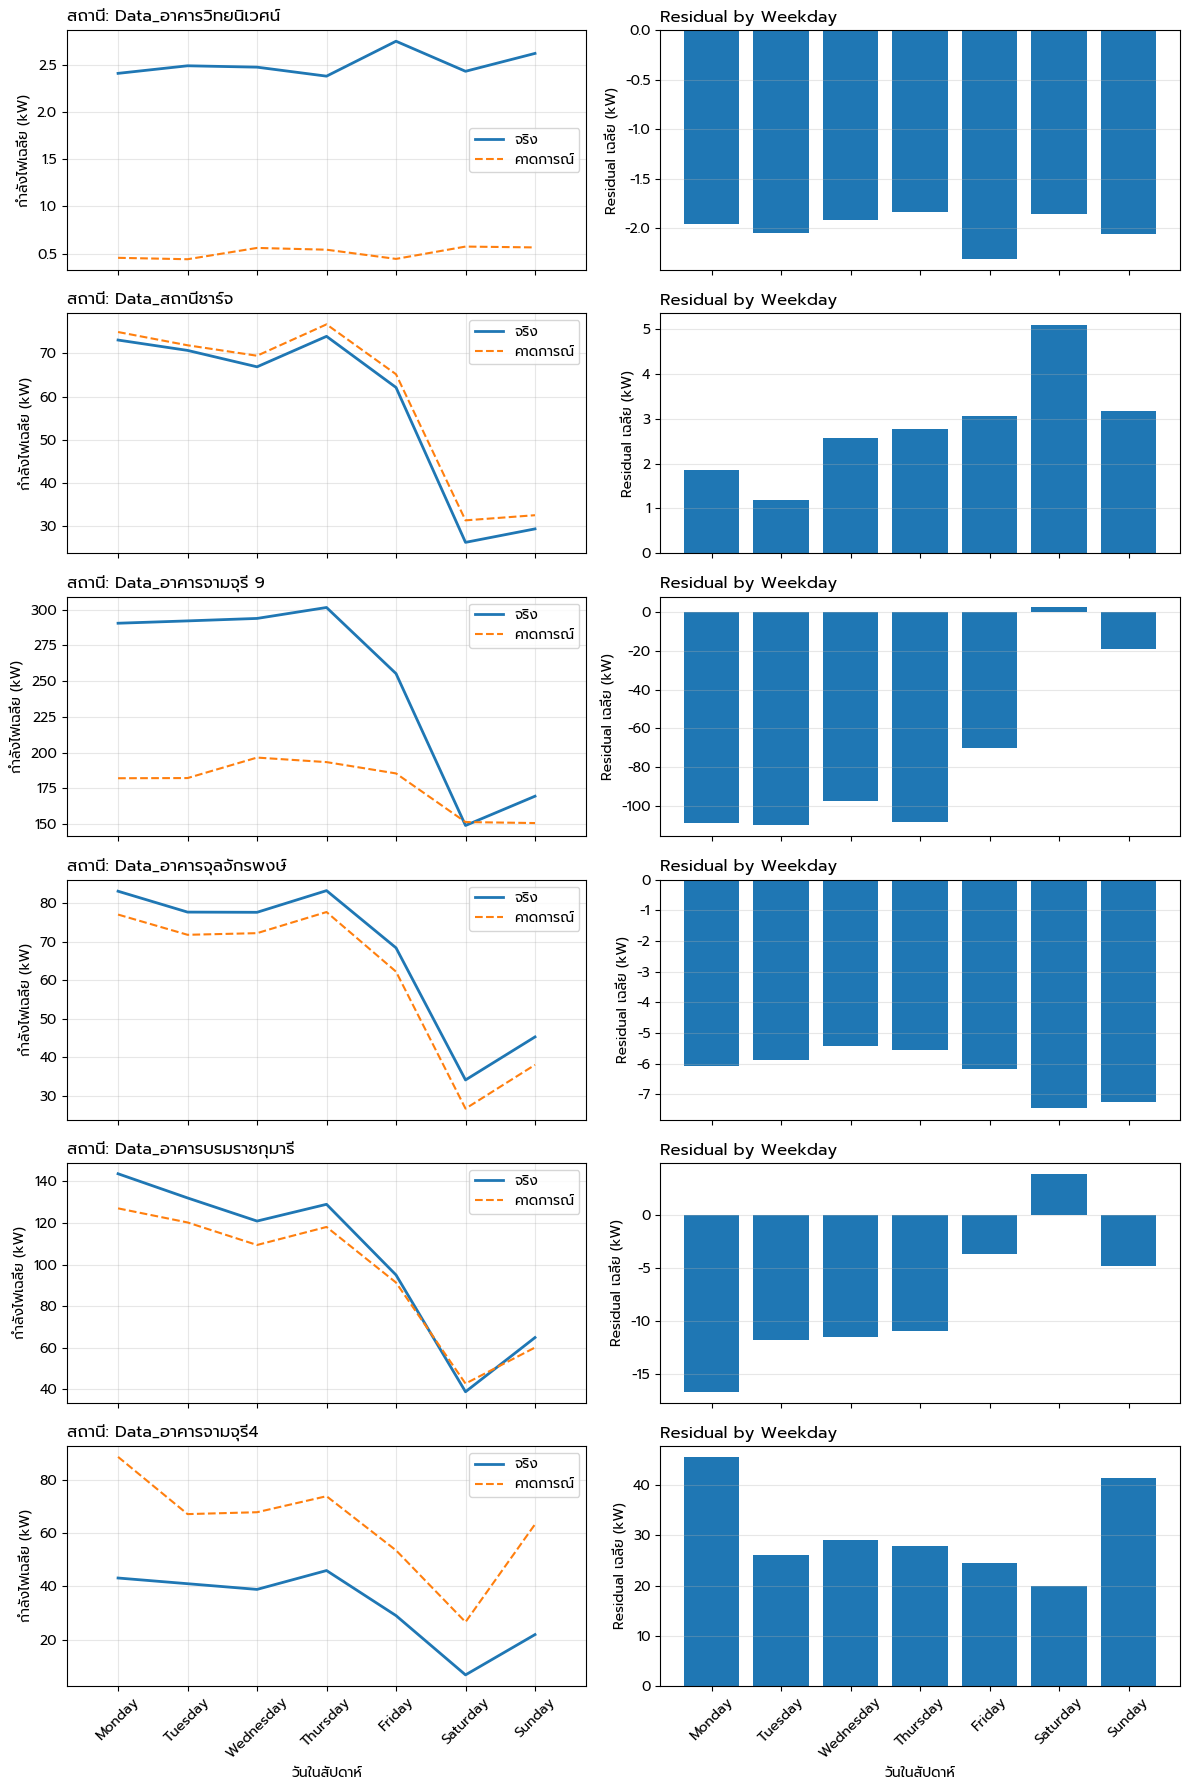

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from utils.error_analyzer import plot_weekday_analysis

plot_weekday_analysis(df_eval, metrics_df)

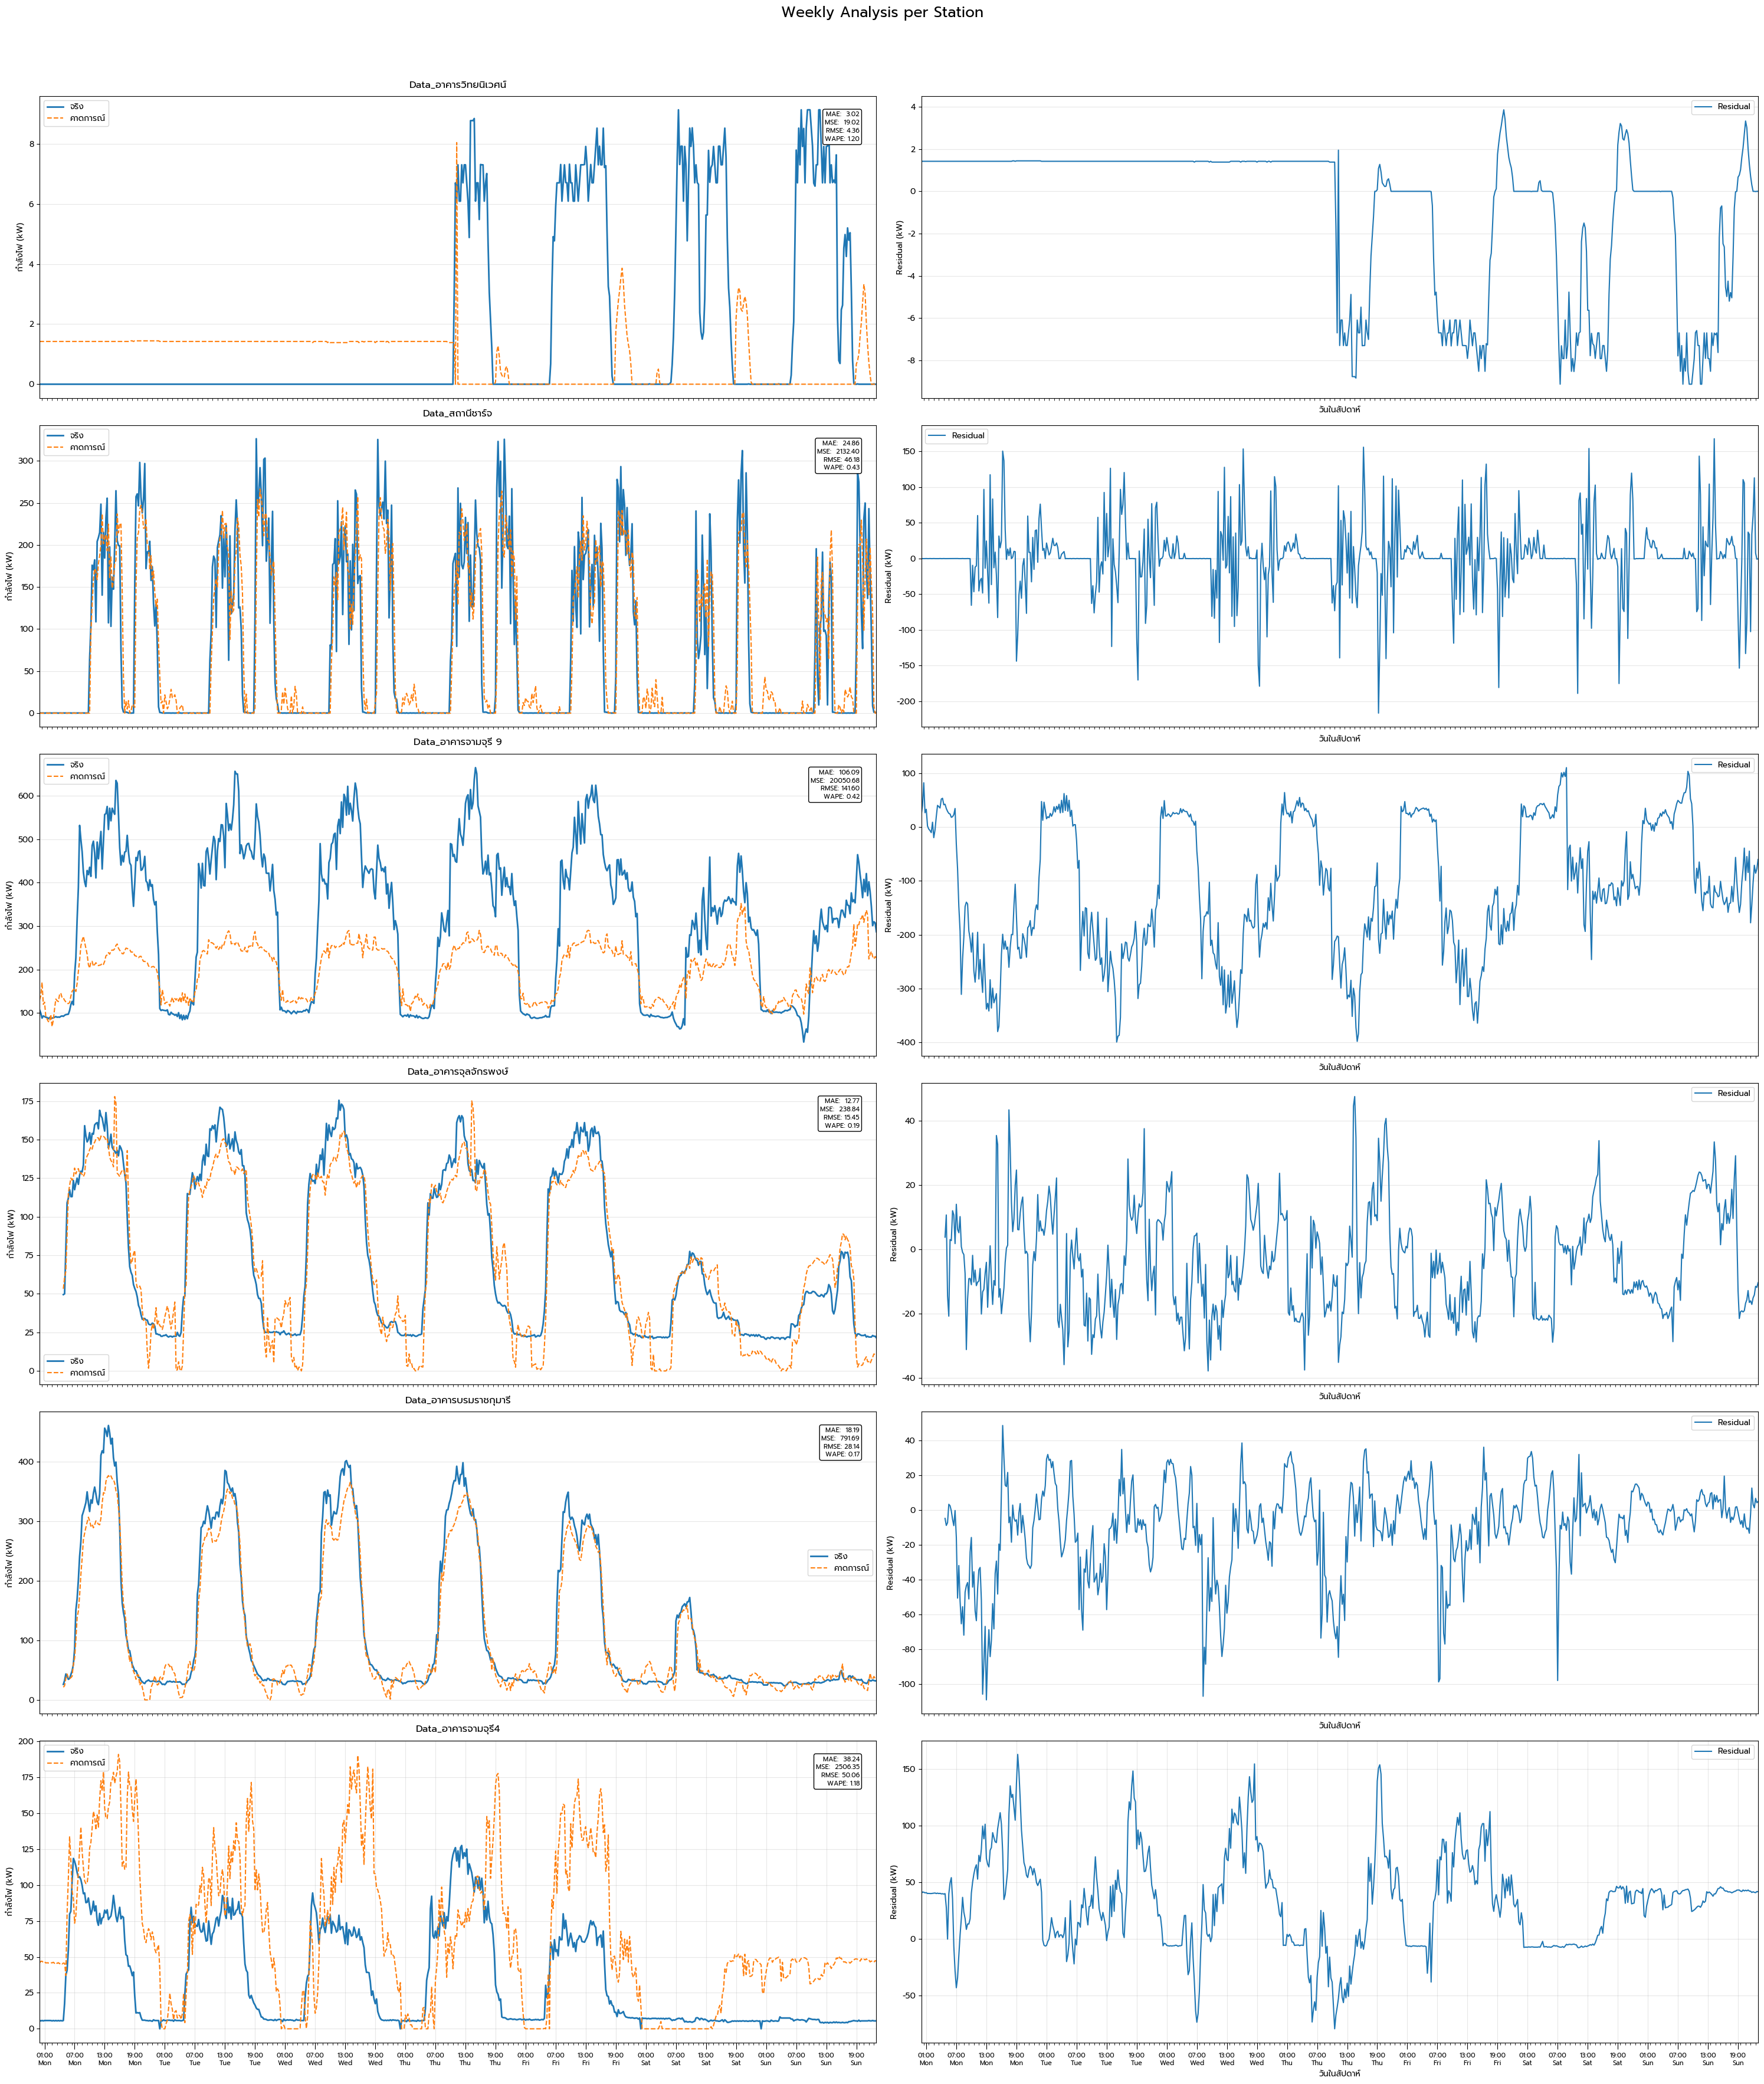

In [ ]:
from utils.error_analyzer import plot_weekly_analysis_combined
# Usage:
plot_weekly_analysis_combined(df_eval, metrics_df)
